# Building Machine Learning Classifiers: Model selection

### Read in & clean text

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Evaluate created features

In [2]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline

C:\Users\deeks\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


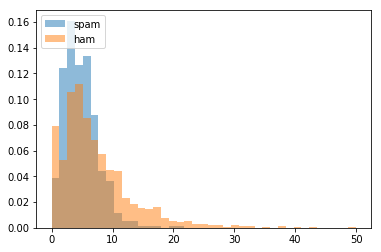

In [3]:
bins = np.linspace(0,50,40)
pyplot.hist(data[data['label']=='spam']['punct%'] , bins , alpha = 0.5 , normed = True ,label = 'spam' )
pyplot.hist(data[data['label']=='ham']['punct%'],bins ,alpha =0.5,normed =True, label = 'ham')
pyplot.legend(loc = 'upper left')
pyplot.show()

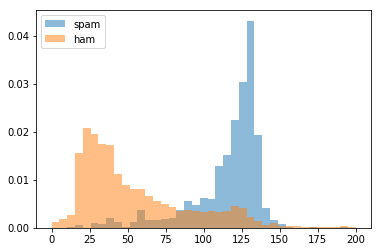

In [4]:
bins = np.linspace(0,200,40)
pyplot.hist(data[data['label']=='spam']['body_len'] , bins , alpha = 0.5 , normed = True ,label = 'spam' )
pyplot.hist(data[data['label']=='ham']['body_len'],bins ,alpha =0.5,normed =True, label = 'ham')
pyplot.legend(loc = 'upper left')
pyplot.show()

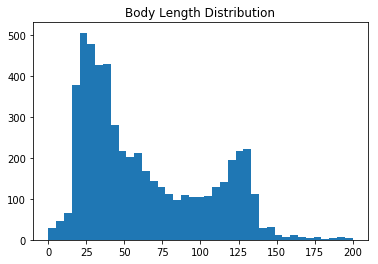

In [5]:
bins = np.linspace(0,200,40)

pyplot.hist(data['body_len'],bins)
pyplot.title("Body Length Distribution")
pyplot.show()

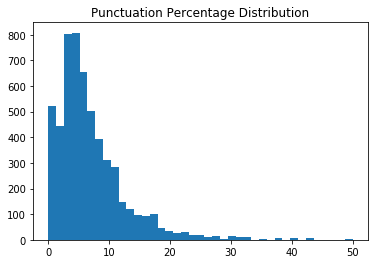

In [6]:
bins = np.linspace(0,50,40)

pyplot.hist(data['punct%'],bins)
pyplot.title("Punctuation Percentage Distribution")
pyplot.show()

### Split into train/test

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

### Vectorize text

In [8]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,7151,7152,7153,7154,7155,7156,7157,7158,7159,7160
0,22,4.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,56,7.1,0.218446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,109,3.7,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,292,7.9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Final evaluation of models

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [10]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end -start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end-start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time : {} / Prdeict time : {} /-------Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time ,3),round(pred_time,3),round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time : 3.357 / Prdeict time : 0.217 /-------Precision: 1.0 / Recall: 0.844 / Accuracy: 0.981


In [10]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end -start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end-start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time : {} / Prdeict time : {} /-------Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time ,3),round(pred_time,3),round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time : 349.684 / Prdeict time : 0.292 /-------Precision: 0.918 / Recall: 0.833 / Accuracy: 0.965
